# Chapter 8 딥러닝
## 8.1 더 깊게
### 8.1.1 더 깊은 신경망으로  
- 3X3의 작은 필터를 사용한 합성곱 계층
- 합성곱 함수는 ReLU
- 완전연결 계층 뒤에 드롭아웃 계층 사용
- Adam을 사용해 최적화
- 가중치 초깃값은 'He의 초깃값'  
 <img style="float: left;" src="equations_and_figures/fig%208-1.png" width="600">

In [1]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *


class DeepConvNet:
    """정확도 99% 이상의 고정밀 합성곱 신경망

    네트워크 구성은 아래와 같음
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        affine - relu - dropout - affine - dropout - softmax
    """
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param_1 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_2 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_3 = {'filter_num':32, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_4 = {'filter_num':32, 'filter_size':3, 'pad':2, 'stride':1},
                 conv_param_5 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_6 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 hidden_size=50, output_size=10):
        # 가중치 초기화===========
        # 각 층의 뉴런 하나당 앞 층의 몇 개 뉴런과 연결되는가（TODO: 자동 계산되게 바꿀 것
        pre_node_nums = np.array([1*3*3, 16*3*3, 16*3*3, 32*3*3, 32*3*3, 64*3*3, 64*4*4, hidden_size])
        wight_init_scales = np.sqrt(2.0 / pre_node_nums)  # ReLU를 사용할 때의 권장 초깃값
        
        self.params = {}
        pre_channel_num = input_dim[0]
        for idx, conv_param in enumerate([conv_param_1, conv_param_2, conv_param_3, conv_param_4, conv_param_5, conv_param_6]):
            self.params['W' + str(idx+1)] = wight_init_scales[idx] * np.random.randn(conv_param['filter_num'], pre_channel_num, conv_param['filter_size'], conv_param['filter_size'])
            self.params['b' + str(idx+1)] = np.zeros(conv_param['filter_num'])
            pre_channel_num = conv_param['filter_num']
        self.params['W7'] = wight_init_scales[6] * np.random.randn(64*4*4, hidden_size)
        self.params['b7'] = np.zeros(hidden_size)
        self.params['W8'] = wight_init_scales[7] * np.random.randn(hidden_size, output_size)
        self.params['b8'] = np.zeros(output_size)

        # 계층 생성===========
        self.layers = []
        self.layers.append(Convolution(self.params['W1'], self.params['b1'], 
                           conv_param_1['stride'], conv_param_1['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W2'], self.params['b2'], 
                           conv_param_2['stride'], conv_param_2['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Convolution(self.params['W3'], self.params['b3'], 
                           conv_param_3['stride'], conv_param_3['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W4'], self.params['b4'],
                           conv_param_4['stride'], conv_param_4['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Convolution(self.params['W5'], self.params['b5'],
                           conv_param_5['stride'], conv_param_5['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W6'], self.params['b6'],
                           conv_param_6['stride'], conv_param_6['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Affine(self.params['W7'], self.params['b7']))
        self.layers.append(Relu())
        self.layers.append(Dropout(0.5))
        self.layers.append(Affine(self.params['W8'], self.params['b8']))
        self.layers.append(Dropout(0.5))
        
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x, train_flg=False):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x, train_flg=True)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx, train_flg=False)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        tmp_layers = self.layers.copy()
        tmp_layers.reverse()
        for layer in tmp_layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            grads['W' + str(i+1)] = self.layers[layer_idx].dW
            grads['b' + str(i+1)] = self.layers[layer_idx].db

        return grads

    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            self.layers[layer_idx].W = self.params['W' + str(i+1)]
            self.layers[layer_idx].b = self.params['b' + str(i+1)]


In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from ch08.deep_convnet import DeepConvNet
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

network = DeepConvNet()  
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=20, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr':0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보관
network.save_params("deep_convnet_params.pkl")
print("Saved Network Parameters!")


train loss:2.2428040898027337
=== epoch:1, train acc:0.127, test acc:0.141 ===
train loss:2.2890740945963826
train loss:2.3008805201566456
train loss:2.3083115542323838
train loss:2.2924042390981425
train loss:2.2654348884736026
train loss:2.279976398874168
train loss:2.25579225406897
train loss:2.24009126040058
train loss:2.24521208015541
train loss:2.2472845308734315
train loss:2.28177302137533
train loss:2.2222052004835344
train loss:2.2582200643845156
train loss:2.199997453211832
train loss:2.223816759815493
train loss:2.1996988236647503
train loss:2.206869128038738
train loss:2.1928955445497644
train loss:2.1506450825821886
train loss:2.148453532526698
train loss:2.152903581860148
train loss:2.1206022314719455
train loss:2.0742623446448016
train loss:2.0238836743448227
train loss:2.0773496539095033
train loss:2.0300765364959084
train loss:2.029787752997638
train loss:2.0099852796219686
train loss:1.9548009667267552
train loss:1.9643555951025824
train loss:2.0471114359338833
train 

train loss:1.0967273009917209
train loss:0.9854808220624095
train loss:1.0702214385854787
train loss:1.208940737370452
train loss:1.0319620422256464
train loss:1.1771884238673553
train loss:1.1471941788990054
train loss:1.3561649901165769
train loss:1.1874027749940632
train loss:1.275055480854319
train loss:1.1329690238436878
train loss:1.2022804831062246
train loss:1.0563689111184558
train loss:1.3221804484779165
train loss:1.1366619545274372
train loss:1.1841926334513997
train loss:1.2850547464048176
train loss:1.1413235622970348
train loss:1.0813670033067484
train loss:1.1169647125131894
train loss:1.1886191187313906
train loss:1.2053913421228963
train loss:1.1239007111824113
train loss:1.1721035602277976
train loss:1.1202511343026127
train loss:1.163538047487814
train loss:1.1852708050848075
train loss:1.0759618044649428
train loss:1.1426222908808703
train loss:1.068732374196572
train loss:1.3270462609420017
train loss:1.0761943143460786
train loss:1.2038072198409822
train loss:1.1

train loss:1.1718863351771471
train loss:1.0871776263849542
train loss:0.8783250294053845
train loss:1.0867119885070589
train loss:0.9855180948008937
train loss:1.1031717029593937
train loss:1.0238182909760827
train loss:1.017194878990402
train loss:0.9449793598821475
train loss:1.0344582955567412
train loss:1.2222634237254701
train loss:1.0246342949186404
train loss:1.129584695299966
train loss:1.0307909993436446
train loss:1.094527290830195
train loss:1.105784003265495
train loss:1.0444592086235047
train loss:1.1045205521018624
train loss:0.9882585652552511
train loss:1.0098067815945362
train loss:1.0943937284866936
train loss:1.1534518518405228
train loss:0.9960678308732469
train loss:1.1074657092868043
train loss:1.0529269946954682
train loss:0.9853868949307192
train loss:1.2294924324594736
train loss:0.8931392851676228
train loss:0.9362806032051227
train loss:1.0195109063217485
train loss:1.0583311970478158
train loss:0.9030940986337349
train loss:0.9961179144871424
train loss:1.0

train loss:1.026775617552102
train loss:0.9638321604074688
train loss:0.984667839514428
train loss:0.991824172420616
train loss:0.9294464317813308
train loss:0.9172311907010426
train loss:1.1227492568244812
train loss:1.182206501384102
train loss:0.9691665044933541
train loss:1.0670733555419536
train loss:0.9727047047495525
train loss:0.9841543789133543
train loss:0.9452087778375287
train loss:1.0250681024084274
train loss:0.8593819705734341
train loss:1.1193345200615468
train loss:0.9940337026552565
train loss:0.9238201222698228
train loss:1.025749599562372
train loss:0.8780817374341732
train loss:0.8877338809126608
train loss:1.099720850281629
train loss:1.2178317946693944
train loss:0.9876824580732522
train loss:1.0001458319361363
train loss:1.215468694475375
train loss:0.8792607646341578
train loss:0.9794663965539988
train loss:0.8552589482339735
train loss:0.8010061279473761
train loss:0.9909711995860806
train loss:0.9973080181677442
train loss:1.1721813590880932
train loss:1.0230

train loss:0.9682988761161782
train loss:0.886904760690031
train loss:1.0510793416805684
train loss:0.9812198010314455
train loss:0.898113124228116
train loss:0.9989033972428465
train loss:1.0955694178021704
train loss:1.1144029035638296
train loss:0.9833356249284851
train loss:1.0390623229606377
train loss:0.7796193285871879
train loss:1.0086918162189646
train loss:0.953884425377083
train loss:0.768463675105326
train loss:0.8440342258262874
train loss:0.9977097002532364
train loss:0.915221368114568
train loss:1.0905291763631242
train loss:1.0982448283072421
train loss:0.9899068793116426
train loss:0.8876733343263696
train loss:1.085621733648411
train loss:1.0058517161760019
train loss:0.9775658402044316
train loss:1.0088100843388943
train loss:1.1249712547133561
train loss:0.9816814528881556
train loss:1.1044340196885283
train loss:1.0667314870170355
train loss:1.0163539065131375
train loss:0.9669736856954628
train loss:0.9418343515954914
train loss:0.9684161410284291
train loss:0.934

train loss:1.0637757095451994
train loss:0.9453533440982131
train loss:1.0431591434581913
train loss:1.0057597886173035
train loss:1.02826584162479
train loss:1.0194366942284074
train loss:0.7939662754496537
train loss:0.8954418812112148
train loss:0.8041084462724645
train loss:0.9354788906386845
train loss:0.9035378893919166
train loss:0.8645027739236631
train loss:0.8716687282331528
train loss:0.9126630712792935
train loss:0.8512192546447941
train loss:0.9285113773490116
train loss:0.8669692263994232
train loss:0.9727686804005478
train loss:0.8893837977112381
train loss:0.9053868163202534
train loss:0.8845747724801786
train loss:0.9712150573882069
train loss:0.9944326727908746
train loss:0.8097004819363411
train loss:0.9132546679957606
train loss:0.8939282048823355
train loss:1.0096520458264342
train loss:0.8472327473259631
train loss:1.0299404966145054
train loss:0.9371745436732222
train loss:1.0179214429707393
train loss:0.7431597018925415
train loss:0.8891109659821314
train loss:0

train loss:0.9329423498937187
train loss:0.9398311748362411
train loss:0.8644868136617773
train loss:0.8924022271792772
train loss:0.9714598790622682
train loss:0.9478288562212788
train loss:0.8628528875951678
train loss:0.937115308016663
train loss:0.9393759956912843
train loss:0.876853068756046
train loss:0.9496042105940288
train loss:0.9324611380516689
train loss:0.7522645618930988
train loss:0.8717723943260539
train loss:0.9283164117077919
train loss:0.9266760207143879
train loss:1.0119938525817074
train loss:0.939416495994383
train loss:0.9976983800438499
train loss:0.8201259868728276
train loss:0.9986602424198364
train loss:0.8943550937039286
train loss:0.9733355489272504
train loss:1.0740205688919129
train loss:0.9932745949323314
train loss:0.8034724676604361
train loss:0.9180906003729769
train loss:1.0810474738881475
train loss:0.8810187693475597
train loss:0.9104710947803625
train loss:0.8679180579627515
train loss:0.9394684671314899
train loss:0.8160516188211383
train loss:0.

train loss:0.9468438151890354
train loss:1.0162650949067997
train loss:0.8208817916644091
train loss:0.927918951715268
train loss:1.0229100070832842
train loss:0.9326305598898275
train loss:1.0400824927557992
train loss:0.8205786554213305
train loss:1.048437251663527
train loss:0.8843344787429231
train loss:1.108475023815454
train loss:0.9679021788209319
train loss:0.8609691539434355
train loss:0.7650604061670648
train loss:1.0310888502843207
train loss:1.1720636072477155
train loss:0.721306045257515
train loss:0.9434453795911497
train loss:0.9830721275963531
train loss:0.8807134613447423
train loss:0.7639874246348838
train loss:0.8126085126552514
train loss:0.866352770966914
train loss:0.9085676660653366
train loss:0.856653476336263
train loss:1.0001724578248576
train loss:0.9185118774710108
train loss:0.8103220276751195
train loss:0.9346085166327508
train loss:0.8976403163747264
train loss:0.9193928678701704
train loss:0.9572312922619212
train loss:1.022506511499233
train loss:1.0215

train loss:0.9269440327455384
train loss:0.8931503029265013
train loss:0.9005512661167989
train loss:0.9074502346145149
train loss:0.9062474977243946
train loss:0.8280220355966409
train loss:0.9446125464539783
train loss:0.6205652563983677
train loss:0.8269681799959037
train loss:0.8785193079384613
train loss:1.1009493985024954
train loss:0.7291525619897967
train loss:0.8550307295414653
train loss:0.9118283982926108
train loss:0.7443835565746443
train loss:0.8989687979735683
train loss:0.7796538780917328
train loss:0.9764184165363374
train loss:0.9026783764718798
train loss:0.9841403971969223
train loss:0.8281943094345529
train loss:0.9474056729563071
train loss:0.7905902057827661
train loss:0.9546233018147845
train loss:1.0063302793728963
train loss:0.859538019012698
train loss:0.853727884213301
train loss:0.9221780354047054
train loss:0.8847548678823607
train loss:0.8553097505959824
train loss:1.0634916585104643
train loss:0.824974919065685
train loss:1.0893769368869655
train loss:1.

train loss:1.000233821799805
train loss:0.871990426669344
train loss:0.9409405871908261
train loss:0.9286536660177254
train loss:0.8926319992647572
train loss:0.9315957731544594
train loss:0.661773598912581
train loss:0.9022526925509149
train loss:0.9911658547842974
train loss:0.799064088680023
train loss:0.7881141818438827
train loss:1.0048159278459985
train loss:0.7642269761475178
train loss:0.8947244614322974
train loss:0.7974019534999103
train loss:0.7696999037991159
train loss:0.7835795524782668
train loss:0.9880272596917711
train loss:0.7275819918471954
train loss:0.8881379783055123
train loss:0.7036143420503775
train loss:0.7811091691353695
train loss:0.9205462920247873
train loss:0.8305544406711062
train loss:0.9568536563321686
train loss:0.9903401360147526
train loss:1.060540282047201
train loss:1.042522164695518
train loss:1.0212392485455644
train loss:0.9639784913119677
train loss:0.9577273537293362
train loss:0.9047950204481984
train loss:0.9375583214038029
train loss:1.080

train loss:0.9005366765578886
train loss:0.8965423627127477
train loss:0.8115292053118581
train loss:0.9198200595361263
train loss:1.0279675833353619
train loss:0.7538834295344823
train loss:0.808525637015054
train loss:0.951482469155057
train loss:0.9208445768875702
train loss:0.8715407408354381
train loss:0.9708345419161094
train loss:0.8142618676503948
train loss:0.9016765608685321
train loss:0.894761548375746
train loss:1.0476451597102114
train loss:0.8568946699648005
train loss:0.8149578787243609
train loss:0.7856994811546639
train loss:0.6923190665458047
train loss:0.8675487844095473
train loss:0.724997453025198
train loss:0.7060694143082141
train loss:0.9071050329621657
train loss:0.9180823788595721
train loss:0.9456701731262855
train loss:0.9729542757846374
train loss:0.8705185419142443
train loss:0.9054952041624559
train loss:0.7563855983246923
train loss:0.962341808562734
train loss:0.8555791538867524
train loss:0.8915653893955953
train loss:0.8767489059516228
train loss:0.93

train loss:0.8797262587855377
train loss:0.7863742999639126
train loss:0.9484846171183701
train loss:0.8611786421520591
train loss:0.8698962345178438
train loss:0.9452969879499808
train loss:0.7627606836998944
train loss:1.0504860485895693
train loss:0.8517304465732458
train loss:0.9449933931925064
train loss:1.121794791430022
train loss:0.9519194083895072
train loss:0.9386786412678515
train loss:0.9466761231670543
train loss:0.9324944774277966
train loss:0.9012003597485545
train loss:0.9645605717925791
train loss:1.008927383922874
train loss:0.9068329226859493
train loss:0.8556164357233668
train loss:0.8928278242893805
train loss:0.9491073332614286
train loss:0.8432978622213573
train loss:0.986577301949267
train loss:0.8317782351448212
train loss:0.9460201457330849
train loss:0.9779194164136367
train loss:0.6930895429974763
train loss:0.8764364640122256
train loss:0.8016435727547021
train loss:0.83362632032164
train loss:0.9756976009250365
train loss:0.7071641136615822
train loss:0.93

train loss:1.063689920202109
train loss:0.7969028105976474
train loss:0.8188015861099636
train loss:0.9334753847686561
train loss:0.8880974132211489
train loss:0.7266368448229958
train loss:0.7726110526875639
train loss:0.9983237855533343
train loss:0.8837448420453431
train loss:0.951883314465419
train loss:0.8628839174538132
train loss:0.9827536639854363
train loss:0.8378969439062839
train loss:0.7578183717842956
train loss:0.7814269265725757
train loss:0.9203205081281557
train loss:1.1160088508256139
train loss:0.7588186486973446
train loss:0.7764676683339594
train loss:0.9253841563101329
train loss:0.8756669001516457
train loss:0.8827540540648338
train loss:0.9252025014798716
train loss:0.9973825655413985
train loss:0.9164087044586777
train loss:0.8242663054119671
train loss:0.9303076509370467
train loss:0.8490240888573863
train loss:1.021952688080428
train loss:0.8742657521490608
train loss:0.9786734850917493
train loss:0.911503570572725
train loss:0.8637178391150213
train loss:1.0

train loss:0.8106194640580883
train loss:0.9223340169337702
train loss:0.8648506689966807
train loss:0.9421037085945321
train loss:1.1571630006893698
train loss:0.820161087894466
train loss:0.9738385862791071
train loss:0.9947752277835988
train loss:0.9825258713995264
train loss:0.9336030764102858
train loss:0.9117437103381206
train loss:0.8994853203395783
train loss:0.9527966926575128
train loss:0.7847439453043542
train loss:0.9129848814317215
train loss:0.6781974913670537
train loss:0.8092484911845577
train loss:0.8187477615082018
train loss:0.9155618796897856
train loss:1.0497012771530343
train loss:0.9889261480934536
train loss:0.759149726770383
train loss:0.8285829535313267
train loss:0.8349941955668774
train loss:0.9644985876061564
train loss:0.7036588280313165
train loss:0.9805508985831568
train loss:0.9134317762799252
train loss:0.8874423336574835
train loss:0.8331007871990538
train loss:0.8345943572455581
train loss:1.0184817198811118
train loss:0.9121855040874121
train loss:0

train loss:0.739780894307044
train loss:0.7483920834447406
train loss:1.0127565484195535
train loss:0.8458387468741134
train loss:0.9204156784289665
train loss:0.9512837253716759
train loss:0.9088561034664656
train loss:0.8984324612992495
train loss:0.7878984302703986
train loss:0.7423226117498176
train loss:0.9584535187468367
train loss:0.7945914471668106
train loss:0.9607441212636781
train loss:0.9388452355822497
train loss:0.8715891229955579
train loss:0.7915978919310973
train loss:0.9191263000733235
train loss:0.8552418251484667
train loss:0.7681136369947899
train loss:0.9024239377411237
train loss:0.9734231639037294
train loss:0.8110158233102421
train loss:0.8705274107159252
train loss:0.7388313949454031
train loss:0.9871721717903792
train loss:0.7702491441118514
train loss:0.975062229282333
train loss:0.7930985217374446
train loss:0.8180139671271374
train loss:0.7944225629008247
train loss:0.852044247906743
train loss:1.0104365147675978
train loss:0.7315601881197459
train loss:0.

train loss:0.9548517302735543
train loss:0.8716737765740661
train loss:0.8257781202622665
train loss:0.9650078349628992
train loss:1.0270886345956822
train loss:0.8939826721305515
train loss:0.8965179491907775
train loss:0.7660452255601088
train loss:0.7715020103737774
train loss:0.8817800958690738
train loss:0.9141125939209966
train loss:0.9349137228286452
train loss:0.7891313273079864
train loss:0.9643892616730055
train loss:0.8819992957140558
train loss:1.016279568820335
train loss:1.0826861400556256
train loss:0.8183911557014254
train loss:0.8159542964623496
train loss:0.8114199884454132
train loss:0.8144770985883903
train loss:0.8776597902786715
train loss:0.9702606935622515
train loss:0.7242513706791488
train loss:0.9494321630783519
train loss:0.898862104507557
train loss:0.9702286818435293
train loss:0.9644616873641171
train loss:0.9520163092942394
train loss:0.7896975034726905
train loss:0.9630489471224922
train loss:0.8157171562909084
train loss:0.9268873044236743
train loss:0

train loss:0.8363165149600776
train loss:0.8666131937632858
train loss:0.874442672788495
train loss:0.911018553146676
train loss:0.7694981306548141
train loss:0.8454100778149778
train loss:0.9652437976992261
train loss:0.9286187001805619
train loss:0.8481143630947316
train loss:0.8846527183469949
train loss:0.9748631697539775
train loss:0.999166439000899
train loss:0.9565327993708266
train loss:0.7671011269257819
train loss:0.8698060239931706
train loss:1.0406833134600197
train loss:0.8455292732795389
train loss:1.0059017024512165
train loss:0.8809422443260023
train loss:0.7639159905912963
train loss:0.9910624885848108
train loss:0.7449132577108345
train loss:0.8317995600806732
train loss:0.8576489285839604
train loss:0.851226598461926
train loss:0.9203463473023799
train loss:0.8975351904324986
train loss:0.8045679586078015
train loss:0.9646957197773323
train loss:0.7209278854066803
train loss:0.9800096634864733
train loss:0.8339948500990019
train loss:0.7219565076809792
train loss:0.8

train loss:0.8091353920299182
train loss:0.9356649762632259
train loss:0.7325961937840999
train loss:0.7279061520472547
train loss:0.9068982659577415
train loss:0.8064009975388566
train loss:0.8591687262051161
train loss:0.783221416050681
train loss:0.91950731616097
train loss:0.9997485990264522
train loss:0.8041647310887191
train loss:0.8942654422757245
train loss:0.934484685890577
train loss:0.8899766074366664
train loss:0.8751530657729003
train loss:0.8526863855647027
train loss:0.7896090579918943
train loss:0.9130139468148522
train loss:0.9106517366299101
train loss:0.8700769297549464
train loss:0.8878308699478122
train loss:0.8297813403225279
train loss:0.7889660150686763
train loss:0.8553465186572516
train loss:0.7664968206569036
train loss:0.9760864389397735
train loss:0.8738635434189632
train loss:0.8870825611216658
train loss:0.7520708076248119
train loss:0.8213322056566517
train loss:0.9676229244128131
train loss:0.8079465260699417
train loss:0.7520355617248466
train loss:0.7

train loss:0.9317852274167113
train loss:0.9463556474992947
train loss:0.7771863492501635
train loss:0.929620115875045
train loss:0.7896973119304955
train loss:0.9534359060683948
train loss:0.7276008035343202
train loss:1.065851964077756
train loss:0.7712704506599691
train loss:0.8528227642131918
train loss:0.8717025337883354
train loss:0.8271618686353887
train loss:0.8919768402308316
train loss:0.808460907488209
train loss:0.8285777216648441
train loss:0.8503807860227276
train loss:1.053075314550188
train loss:0.9911895904736986
train loss:0.8566136790774627
train loss:0.8674387435995463
train loss:0.796742497590122
train loss:0.8050678866288683
train loss:0.8033252072281365
train loss:0.820540448905854
train loss:0.8111786611528845
train loss:0.8638079520681015
train loss:0.6809056474574345
train loss:0.8153837890979364
train loss:0.7737742246245334
train loss:0.9166376830691852
train loss:0.9963604945390546
train loss:0.9152011690108534
train loss:0.8666321951506066
train loss:0.993

train loss:0.6977294776548071
train loss:0.7795549692650617
train loss:0.8470428087515576
train loss:0.9666531276820182
train loss:0.9971797493453903
train loss:1.0250709396195905
train loss:0.9368736396518628
train loss:0.8932689881859679
train loss:0.8937310964235209
train loss:0.7430507005179168
train loss:0.7973964990496563
train loss:0.9106095838003353
train loss:0.8542899004506469
train loss:0.7439836237176695
train loss:0.9138072746181143
train loss:0.8480062960945252
train loss:0.953777862426382
train loss:0.7892774130125878
train loss:0.9139134064984438
train loss:0.7628338826034858
train loss:0.7881651491656078
train loss:0.9810804365837492
train loss:0.9780521288031342
train loss:0.9154657524621729
train loss:0.8711987109622273
train loss:0.7844206035409697
train loss:0.913214245003769
train loss:0.8628073602634178
train loss:0.8607764494646866
train loss:0.7236344788249415
train loss:0.7591841160633073
train loss:0.8889130226474626
train loss:0.9275670175973887
train loss:0

train loss:0.918672096415153
train loss:0.9035926329079932
train loss:0.9646717771191311
train loss:0.7805279109436054
train loss:0.9130454018115874
train loss:0.7448741342386481
train loss:0.808570671527662
train loss:0.6488108800591467
train loss:1.036695776844637
train loss:0.8064020671410962
train loss:0.7113974487442003
train loss:0.9500705495986572
train loss:1.1109103783972443
train loss:0.9074940214070202
train loss:0.836823193842654
train loss:0.9110759891223832
train loss:0.8959292140600139
train loss:0.7096614935241519
train loss:0.8651328484197286
train loss:0.9800192316826127
train loss:0.7741652321858732
train loss:0.9465066103318148
train loss:0.8417898365369674
train loss:0.8223156105560134
train loss:0.9465942148383487
train loss:0.8479845531559579
train loss:0.8222825459185533
train loss:0.8489378449658936
train loss:0.9159977338151712
train loss:0.942907209575552
train loss:0.9818020575353426
train loss:0.8126300364495584
train loss:0.8920112536526709
train loss:0.81

In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from ch08.deep_convnet import DeepConvNet
from dataset.mnist import load_mnist


(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

network = DeepConvNet()
network.load_params("ch08\deep_convnet_params.pkl")

print("calculating test accuracy ... ")
#sampled = 1000
#x_test = x_test[:sampled]
#t_test = t_test[:sampled]

classified_ids = []

acc = 0.0
batch_size = 100

for i in range(int(x_test.shape[0] / batch_size)):
    tx = x_test[i*batch_size:(i+1)*batch_size]
    tt = t_test[i*batch_size:(i+1)*batch_size]
    y = network.predict(tx, train_flg=False)
    y = np.argmax(y, axis=1)
    classified_ids.append(y)
    acc += np.sum(y == tt)
    
acc = acc / x_test.shape[0]
print("test accuracy:" + str(acc))

classified_ids = np.array(classified_ids)
classified_ids = classified_ids.flatten()
 
max_view = 20
current_view = 1

fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.2, wspace=0.2)

mis_pairs = {}
for i, val in enumerate(classified_ids == t_test):
    if not val:
        ax = fig.add_subplot(4, 5, current_view, xticks=[], yticks=[])
        ax.imshow(x_test[i].reshape(28, 28), cmap=plt.cm.gray_r, interpolation='nearest')
        mis_pairs[current_view] = (t_test[i], classified_ids[i])
            
        current_view += 1
        if current_view > max_view:
            break

print("======= misclassified result =======")
print("{view index: (label, inference), ...}")
print(mis_pairs)

plt.show()


 **99.38%**  
 <img style="float: left;" src="equations_and_figures/fig%208-2.png" width="400">

### 8.1.2 정확도를 더 높이려면
 <img style="float: left;" src="equations_and_figures/fig%208-3.png" width="600">

앙상블 학습, 학습률 감소, 데이터 확장 등이 정확도 향상에 공헌  
데이터 확장은 손쉬운 방법이면서도 정확도 개선에 아주 효과적  
**데이터 확장** data augmentation 은 입력 이미지를 '인위적'으로 확장. 데이터가 몇 개 없을 떄 특히 효과적인 수단. **crop**, **flip**   
 <img style="float: left;" src="equations_and_figures/fig%208-4.png" width="500">

### 8.1.3 깊게 하는 이유  
신경망의 매개변수 수가 줄어듬. 층을 깊게 한 신경망은 적은 매개변수로 같은 수준의 표현력을 달성.  
<img style="float: left;" src="equations_and_figures/fig%208-5.png" width="400">
<img style="float: left;" src="equations_and_figures/fig%208-6.png" width="650">

학습의 효율성도 층을 깊게 하는 것의 이점. 학습 데이터의 양을 줄임. (7.6절 정보를 계층적으로 추출)  
정보를 계층적으로 전달할 수 있다는 점  

## 8.2 딥러닝의 초기 역사
**ILSVRC** ImageNet Large Scale Visual Recognition Challenge 2012년 AlexNet 우승 
### 8.2.1 이미지넷  
100만장이 넘는 이미지를 담고 있는 데이터셋  
<img style="float: left;" src="equations_and_figures/fig%208-7.png" width="700">

**분류** Classification **톱-5 오류** top-5 error 확률이 가장 높다고 생각하는 후보 클래스 5개 안에 정답이 포함되지 않은 비율  
<img style="float: left;" src="equations_and_figures/fig%208-8.png" width="600">

### 8.2.2 VGG  
합성곱 계층과 풀링 계층으로 구성되는 '기본적'인 CNN. VGG16, VGG19  
구성이 간단하여 응용하기 좋음. 많은 기술자가 VGG 기반 신경망을 즐겨 사용  
<img style="float: left;" src="equations_and_figures/fig%208-9.png" width="600">

### 8.2.3 GoogLeNet  
그림의 사각형이 합성곱 계층과 풀링 계층 등이 계층 나타냄  
세로 방향 깊이 뿐 아니라 가로 방향도 깊다는 점이 특징  
가로 방향의 '폭' : 인센셥 구조, 크기가 다른 필터와 풀링을 여러 개 적용항여 그 결과를 결합  
1X1의 합성곱 연산은 채널 쪽으로 크기를 줄이는 것으로, 매개변수 제거와 고속 처리에 기여  
<img style="float: left;" src="equations_and_figures/fig%208-10.png" width="800">
<img style="float: left;" src="equations_and_figures/fig%208-11.png" width="500">
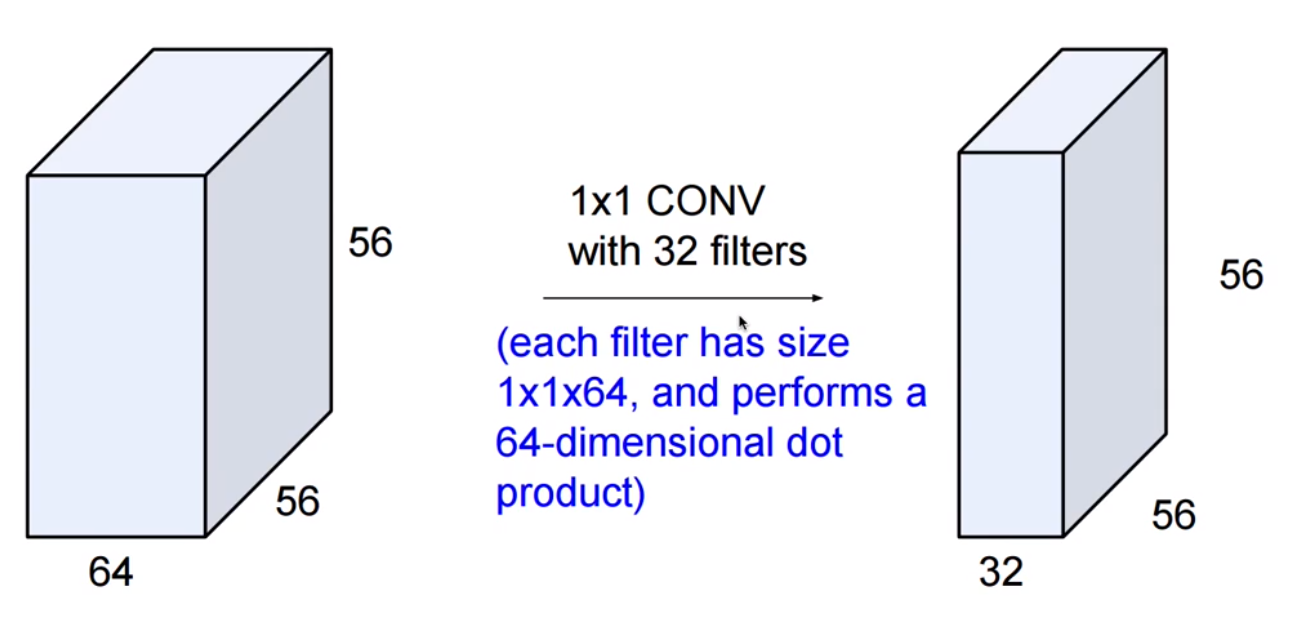

### 8.2.4 ResNet  
**ResNet** Residual Network 마이크로소프트 팀이 개발한 네트워크. 지금까지 보다 층을 더 깊게 할 수 있는 장치.  
층이 지나치게 깊으면 오히려 성능이 떨어짐. **스킵 연결** skip connection 으로 층의 깊이에 비례해 성능 향상.  
스킵 연결이란 입력 데이터를 합성곱 계층을 건너뛰어 출력에 바로 더하는 구조.  
역전파 때도 상류의 기울기를 그대로 하류로 보냄. 의미있는 기울기가 그대로 전해지리라 기대. 기울기 소실 문제를 줄임.
<img style="float: left;" src="equations_and_figures/fig%208-12.png" width="400">
<img style="float: left;" src="equations_and_figures/fig%208-13.png" width="800">

**전이 학습** transfer learning 학습한 가중치 값들을 다른 신경망에 복사한 다음, 그 상태로 재학습을 수행.  
VGG와 구성이 같은 신경망을 준비하고, 미리 학습된 가중치를 초깃값으로 설정, 새로운 데이터셋을 대상으로 재학습(fine tuning).  
전이 학습은 보유한 데이터셋이 적을 때 특히 유용.  

## 8.3 더 빠르게 (딥러닝 고속화)
### 8.3.1 풀어야 할 숙제  
AlexNet에서는 오랜 시간을 합성곱 계층에서 소요. '단일 곱셈-누산'을 어떻게 고속으로 효율적으로 계산하느냐의 문제.
<img style="float: left;" src="equations_and_figures/fig%208-14.png" width="700">

### 8.3.2 GPU를 활용한 고속화  
대량의 병렬 단입 곱셈-누산 (또는 큰 행렬의 곱) 연산은 GPU의 특기. CPU는 연속적인 복잡한 계산을 잘 처리.  
GPU는 주로 엔비디아와 AMD 두 회사가 제공. 딥러닝과 더 '친한' 쪽은 엔비디아.  
엔비디아 GPU 컴퓨팅용 통합 개발 환경인 **CUDA**. **cuDNN**은 CUDA 위에서 동작하는 라이브러리.  
<img style="float: left;" src="equations_and_figures/fig%208-15.png" width="500">

### 8.3.3 분산 학습  
딥러닝 학습을 수평 확장 scale out 분산학습.  
다수의 GPU를 이용한 분산 학습을 지원한 딥러닝 프레임워크 : 구글 텐서플로, 마이크로소프트 CNTK.  
<img style="float: left;" src="equations_and_figures/fig%208-16.png" width="600">

### 8.3.4 연산 정밀도와 비트 줄이기  
메모리 용량과 버스 대역폭 등이 딥러닝 고속화에 병목이 될 수 있음.  
대량의 가중치 매개변수와 중간 데이터를 메모리에 저장.  
GPU의 버스를 흐르는 데이터가 많아져 한계를 넘어서면 병목이 발생. 네트워크로 부고받는 데이터의 비트 수는 최소.  
많은 비트를 사용할수록 계산 오차는 줄어듬 (32bit, 64bit). 그만큼 계산에 드는 비용과 메모리 사용량이 늘고 버스 대역폭에 부담.  
딥러닝은 높은 수치 정밀도를 요구하지 않음. 2016년 엔비디아 GPU **파스칼** Pascal 아키텍쳐는 **16비트 반정밀도** half-precision 지원.

In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from ch08.deep_convnet import DeepConvNet
from dataset.mnist import load_mnist


(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

network = DeepConvNet()
network.load_params("ch08\deep_convnet_params.pkl")

sampled = 10000 # 고속화를 위한 표본추출
x_test = x_test[:sampled]
t_test = t_test[:sampled]

print("caluculate accuracy (float64) ... ")
print(network.accuracy(x_test, t_test))

# float16(반정밀도)로 형변환
x_test = x_test.astype(np.float16)
for param in network.params.values():
    param[...] = param.astype(np.float16)

print("caluculate accuracy (float16) ... ")
print(network.accuracy(x_test, t_test))

## 8.4 딥러닝의 활용
컴퓨터 비전 분야를 중심으로 몇 가지 소개  
### 8.4.1 사물 검출  
이미지 속에 담긴 사물의 위치와 종류(클래스)를 알아내는 기술.  
<img style="float: left;" src="equations_and_figures/fig%208-17.png" width="600">

**R-CNN** Regions with Convolutional Neural Network 가 유명. 사물이 위치한 영역을 찾아내고(Selective search), CNN을 적용하여 클래스 분류.  
**Faster R-CNN** : 후보 영역 추출까지 CNN으로 처리, 아주 빠름.  
<img style="float: left;" src="equations_and_figures/fig%208-18.png" width="600">

### 8.4.2 분할  
**분할** segmentation 이란 이미지를 픽셀 수준에서 분류하는 문제. 픽셀 단위마다 지도 supervised 데이터를 사용해 학습.  
**FCN** Fully Convolutional Network : 단 한 번의 forward 처리로 모든 픽셀의 클래스를 분류.  
FCN의 마지막에 수행하는 확대는 이중 선형 보간 bilinear interpolation에 의한 선형 확대. 역합성곱 deconvolution 연산으로 구현.  
<img style="float: left;" src="equations_and_figures/fig%208-19.png" width="600">
<img style="float: left;" src="equations_and_figures/fig%208-20.png" width="600">

### 8.4.3 사진 캡션 생성  
사진을 주면 그 사진을 설명하는 글 (캡션)을 자동으로 생성하는 연구. 컴퓨터 비전과 자연어를 융합.  
NIC Neural Image Caption 모델이 대표적. 심층 CNN과 자연어를 다루는 **순환 신경망** Recurrent Neural Network (RNN) 로 구성.  
RNN은 순환적 관계를 갖는 신경망으로 자연어나 시계열 데이터 들의 연속된 데이터를 다룰 때 활용.  
사진이나 자연어와 같은 여러 종류의 정보를 조합하고 처리하는 것을 **멀티모달 처리** multimodal processing.  
<img style="float: left;" src="equations_and_figures/fig%208-21.png" width="600">
<img style="float: left;" src="equations_and_figures/fig%208-22.png" width="600">

## 8.5 딥러닝의 미래
### 8.5.1 이미지 스타일(화풍) 변환  
[A Neural Algorithm of Artistic Style] 논문. 이미지 두 장을 넣어서 화풍을 모방.  
네트워크의 중간 데이터가 콘텐츠 이미지의 중간 데이터와 비슷해지도록 학습. '스타일 행렬' 오차를 줄이도록 학습.  
<img style="float: left;" src="equations_and_figures/fig%208-23.png" width="600">

### 8.5.2 이미지 생성  
대량의 이미지를 학습 후 입력 이미지 없이 새로운 그림을 그려냄. **DCGAN** Deep Convolutional Generative Adversarial Network.  
생성자 Generator와 식별자 Discriminator로 불리는 2개의 신경망을 이용. **GAN** Generative Adversarial Network.  
<img style="float: left;" src="equations_and_figures/fig%208-24.png" width="700">

### 8.5.3 자율 주행  
주위 환경을 올바르게 인식하는 기술이 가장 중요. **SegNet** CNN 기반 신경망.  
<img style="float: left;" src="equations_and_figures/fig%208-25.png" width="600">

### 8.5.4 Deep Q-Network (강화학습)  
시행착오 과정에서 스스로 학습하는 분야: **강화학습** reinforcement learning.  
더 나은 보상을 받는 쪽으로 에이전트의 행동 지침을 학습.  
<img style="float: left;" src="equations_and_figures/fig%208-26.png" width="300">

**Deep Q-Network** (DQN). Q학습에서는 최적 행동 가치 함수로 최적 행동을 정함. CNN으로 이 함수를 흉내 내어 사용.  
CNN은 게임 영상 프레임을 입력하여 게임을 제어하는 움직임에 대하여 각 동작의 가치를 출력.  
<img style="float: left;" src="equations_and_figures/fig%208-27.png" width="700">

## 8.6 정리  
- 수 많은 문제에서 신경망을 더 깊게 하여 성능을 개선할 수 있다.
- 이미지 인식 기술 대회인 ILSVRC에서는 최근 딥러닝 기반 기법이 상위권을 독점하고 있으며, 그 깊이도 더 깊어지는 추세다.
- 유명한 싱경망으로는 VGG, GoogLeNet, ResNet이 있다.
- GPU와 분산 학습, 비트 정밀도 감소 등으로 딥러닝을 고속화할 수 있다.
- 딥러닝(신경망)은 사물 인식뿐 아니라 사물 검출과 분할에도 이용할 수 있다.
- 딥러닝의 응용 분야로는 사진의 캡션 생성, 이미지 생성, 강화학습 등이 있다. 최근에는 자율 주행에도 딥러닝을 접목하고 있어 기대된다.